### Required libraries
    pynufft 
    librosa 
    matplotlib 
    numpy 
    scipy

## Frequency Domain Interpolation ( Linear and 3-degree polynomial interpolation )

### With sampling fraction of 0.5

MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: 7.862888666828076e-06
MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: 0.0017418116437068695
PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: 14.783790765771982
MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: 5.482914510450367e-06
MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: 0.0015119950361626308
PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: 16.349497285506743


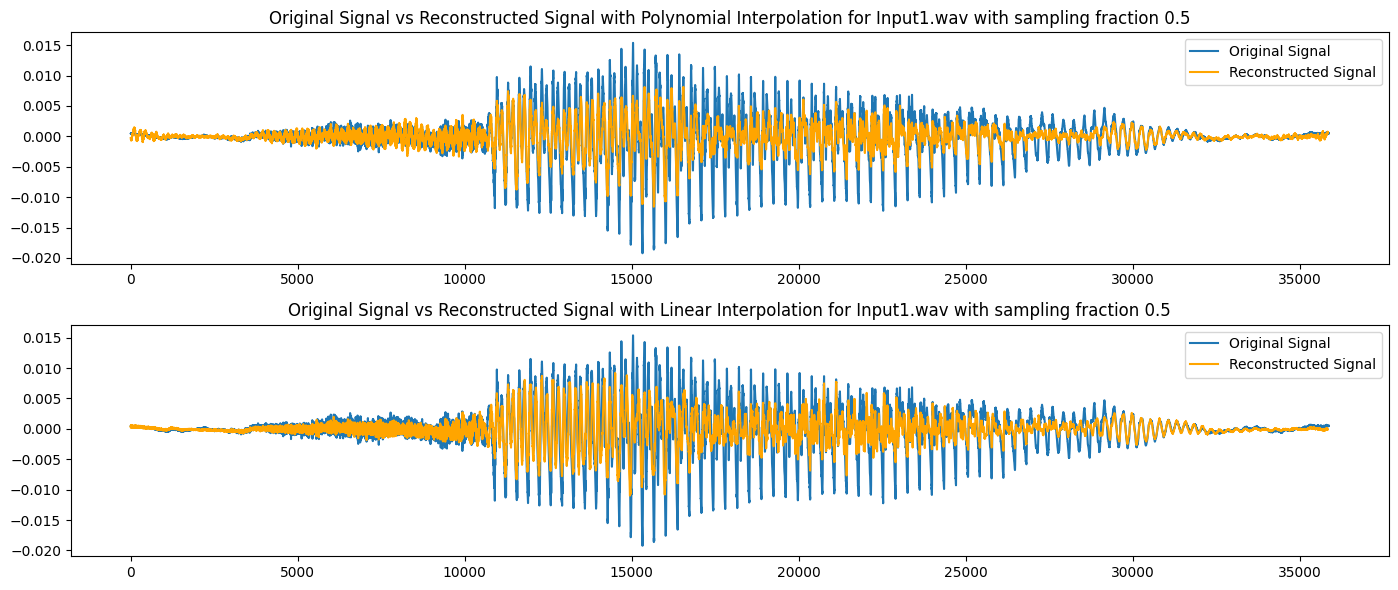

In [13]:
# Import necessary libraries for audio processing, numerical operations, and plotting
import librosa  # Used for audio loading and signal processing
import numpy as np # Used for numerical operations
import matplotlib.pyplot as plt # Used for plotting graphs
from scipy.interpolate import interp1d # Used for interpolation in numerical data

# Load the audio file
file_path = "./input/Input1.wav"
signal, sr = librosa.load(file_path, sr=None) # Load the audio file, `signal` contains the audio samples, `sr` is the sampling rate

# Set a random seed to make all random operations deterministic
np.random.seed(42)

# Define a function to simulate non-uniform sampling of a signal's frequency domain
def simulate_non_uniform_sampling(signal, sample_fraction=0.5):
    """
    Simulate non-uniform sampling by randomly selecting a subset of the Short-Time Fourier Transform (STFT) frequency components.

    Parameters:
    signal: ndarray - the input signal array in the time domain.
    sample_fraction: float - the fraction of frequency components to retain.

    Returns:
    non_uniform_stft: ndarray - the STFT with non-uniformly sampled frequency components set to zero.
    mask: ndarray - a boolean mask where True indicates a retained frequency component.
    original_stft: ndarray - the full STFT of the original signal.
    """
    stft = librosa.stft(signal) # Compute the short-time Fourier transform of the input signal
    mask = np.random.rand(*stft.shape) < sample_fraction # Create a mask with True values at positions where components are retained
    non_uniform_stft = np.where(mask, stft, 0) # Apply the mask to the STFT, setting unselected components to zero
    return non_uniform_stft, mask, stft # Return the non-uniform STFT, the mask, and the original STFT

# Frequency Domain Interpolation function
def frequency_domain_interpolation(non_uniform_stft):
    """
    Interpolate missing values in the frequency domain using linear interpolation.

    Parameters:
    non_uniform_stft: ndarray - the STFT array with non-uniformly sampled frequency components (some set to zero).

    Returns:
    interpolated_stft: ndarray - the STFT array after interpolation.
    """
     # Initialize the output array with complex zeros
    interpolated_stft = np.zeros_like(non_uniform_stft, dtype=complex)
    # Iterate over each frequency bin
    for i in range(non_uniform_stft.shape[0]): 
        # Find indices of known values (non-zero)
        known_indices = np.nonzero(non_uniform_stft[i])[0] 
        # Check if there are at least two points to interpolate between
        if len(known_indices) < 2:
            continue
        # Extract the known values from the STFT
        known_values = non_uniform_stft[i, known_indices]
        # Create a linear interpolation function
        f = interp1d(known_indices, known_values, kind='linear', fill_value="extrapolate")
        # Apply the interpolation across the entire frequency bin
        interpolated_stft[i, :] = f(np.arange(non_uniform_stft.shape[1]))
    return interpolated_stft # Return the interpolated STFT


# Define a function for polynomial frequency domain interpolation
def polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree=3):
    """
    Interpolates missing values in the frequency domain using polynomial fitting.

    Parameters:
    non_uniform_stft: ndarray - the STFT array with non-uniformly sampled frequency components.
    mask: ndarray - a boolean array indicating where frequency components are known.
    degree: int - the degree of the polynomial used for interpolation.

    Returns:
    interpolated_stft: ndarray - the STFT array after polynomial interpolation.
    """
    # Initialize the output array with complex zeros
    interpolated_stft = np.zeros_like(non_uniform_stft, dtype=complex)
    
    # Process each frequency bin independently
    for freq_bin in range(non_uniform_stft.shape[0]):
        # Extract known samples based on the mask
        known_samples = non_uniform_stft[freq_bin, mask[freq_bin]]
        # Get the indices of known samples
        known_indices = np.where(mask[freq_bin])[0]
        
        # Skip bins with too few points to fit the desired polynomial degree
        if len(known_samples) <= degree:
            continue
        
        # Fit a polynomial to the known samples in this frequency bin
        poly_coeffs = np.polyfit(known_indices, known_samples, degree)
        
        # Use the polynomial to estimate values across the entire frequency bin
        all_indices = np.arange(non_uniform_stft.shape[1])
        # Evaluate the polynomial at all points
        estimated_values = np.polyval(poly_coeffs, all_indices)
        
        # Store the estimated values
        interpolated_stft[freq_bin, :] = estimated_values
    
    # Replace the known values with their original values to preserve accuracy
    interpolated_stft[mask] = non_uniform_stft[mask]

    # Return the interpolated STFT
    return interpolated_stft 

# Define a function to reconstruct the time-domain signal from an interpolated STFT
def reconstruct_signal(interpolated_stft):
    """Reconstructs a time-domain signal from its interpolated STFT.

    Parameters:
    - interpolated_stft: ndarray, the STFT matrix after interpolation.

    Returns:
    - time_domain_signal: ndarray, the reconstructed signal in the time domain.
    """
    # Inverse STFT to convert back to time domain
    return librosa.istft(interpolated_stft)

# Define a function to evaluate the mean squared error between the original and reconstructed signals
def evaluate_mse(original_signal, reconstructed_signal):
    """Calculates the mean squared error between the original and reconstructed signals.

    Parameters:
    - original_signal: ndarray, the original signal.
    - reconstructed_signal: ndarray, the reconstructed signal.

    Returns:
    - mse: float, the calculated mean squared error.
    """
    # Determine the minimum length to compare
    min_len = min(len(original_signal), len(reconstructed_signal))
    # Calculate MSE over the common length
    mse = np.mean((original_signal[:min_len] - reconstructed_signal[:min_len])**2)
    return mse

# Define a function to evaluate the Peak Signal to Noise ratio between the original and reconstructed signals
def PSNR(original, reconstructed):
    """Calculates the peak signal to noise ratio between the original and reconstructed signals.

    Parameters:
    - original_signal: ndarray, the original signal.
    - reconstructed_signal: ndarray, the reconstructed signal.

    Returns:
    - psnr: float, the calculated mean squared error.
    """
    mse = evaluate_mse(original, reconstructed)
    if mse == 0:
        return 100
    max_intensity = np.max(original)
    return 20 * np.log10(max_intensity / np.sqrt(mse))

# Define a function to evaluate the mean intensity error between the original and reconstructed signals
def MIE(original, reconstructed):
    """Calculates the mean intensity error between the original and reconstructed signals.

    Parameters:
    - original_signal: ndarray, the original signal.
    - reconstructed_signal: ndarray, the reconstructed signal.

    Returns:
    - mie: float, the calculated mean intensity error.
    """
    # Determine the minimum length to compare
    min_len = min(len(original), len(reconstructed))
    return np.mean(np.abs(original[:min_len] - reconstructed[:min_len]))

# Main execution workflow
# Simulate non-uniform sampling with 50% of the data
non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal)

# Perform frequency domain interpolation
linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)

# Set degree for polynomial interpolation
degree = 3
# Interpolate using polynomial method
polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree)

# Reconstruct signals from interpolated STFT
linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)

# Evaluate and print MSE for both interpolation methods
mse = evaluate_mse(signal, linear_reconstructed_signal)
mie = MIE(signal, linear_reconstructed_signal)
psnr = PSNR(signal, linear_reconstructed_signal)
print(f"MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.5: {psnr}")
mse = evaluate_mse(signal, polynomial_reconstructed_signal)
mie = MIE(signal, polynomial_reconstructed_signal)
psnr = PSNR(signal, polynomial_reconstructed_signal)
print(f"MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.5: {psnr}")

# Plotting setup for visualizing original and reconstructed signals
plt.figure(figsize=(14, 6))

# Subplot for polynomial interpolation results
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Polynomial Interpolation for Input1.wav with sampling fraction 0.5")
plt.legend()
plt.plot(polynomial_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

# Subplot for linear interpolation results
plt.subplot(2, 1, 2)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Linear Interpolation for Input1.wav with sampling fraction 0.5")
plt.legend()
plt.plot(linear_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

### With sampling fraction of 0.1

MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: 2.8427684625172614e-05
MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: 0.003955689861123716
PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: 9.202197142083659
MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: 4.733029480796348e-05
MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: 0.004979638260094492
PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: 6.988219933890419


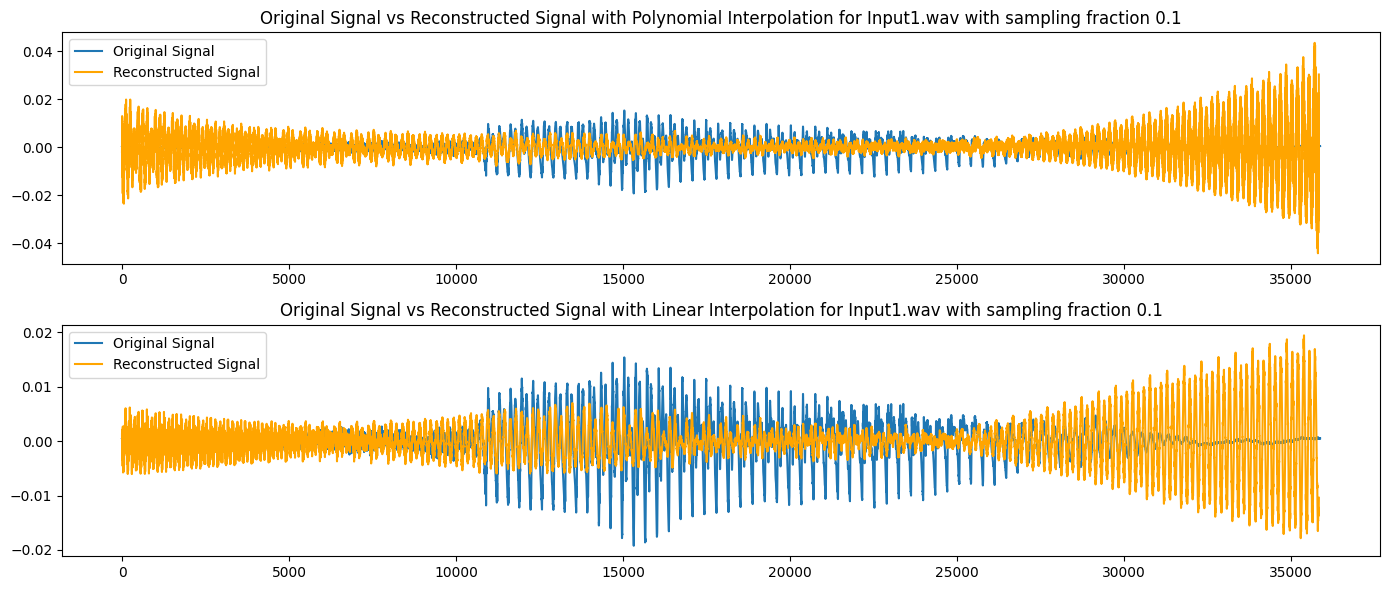

In [14]:
# Simulate non-uniform sampling with 0.1 sampling fraction
np.random.seed(42)
non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal, sample_fraction=0.1)

# Perform frequency domain interpolation
linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)

degree = 3
polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree)

# Reconstruct signal from interpolated STFT
linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)

# Evaluate MSE, MIE, PSNR
mse = evaluate_mse(signal, linear_reconstructed_signal)
mie = MIE(signal, linear_reconstructed_signal)
psnr = PSNR(signal, linear_reconstructed_signal)
print(f"MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: {mse}")
print(f"MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: {mie}")
print(f"PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.1: {psnr}")
mse = evaluate_mse(signal, polynomial_reconstructed_signal)
mie = MIE(signal, polynomial_reconstructed_signal)
psnr = PSNR(signal, polynomial_reconstructed_signal)
print(f"MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: {mse}")
print(f"MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: {mie}")
print(f"PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.1: {psnr}")

# Plot original and reconstructed signal
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Polynomial Interpolation for Input1.wav with sampling fraction 0.1")
plt.legend()
plt.plot(polynomial_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Linear Interpolation for Input1.wav with sampling fraction 0.1")
plt.legend()
plt.plot(linear_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

### With sampling fraction of 0.9

MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: 9.446094532960746e-07
MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: 0.0005894931562169868
PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: 23.987089154533795
MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: 4.25567426636006e-07
MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: 0.0004196837783518443
PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: 27.449928237542114


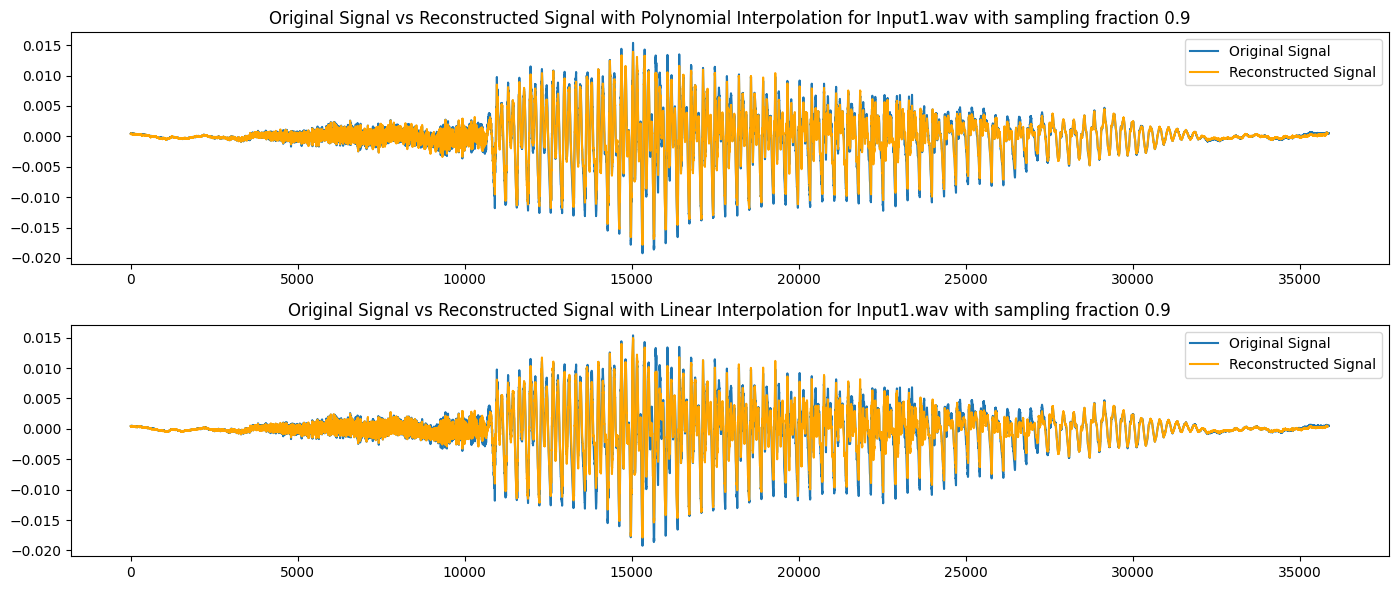

In [15]:
# Simulate non-uniform sampling with 0.9 sampling fraction
np.random.seed(42)
non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal, sample_fraction=0.9)

# Perform frequency domain interpolation
linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)

degree = 3
polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree)

# Reconstruct signal from interpolated STFT
linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)

# Evaluate MSE, MIE, PSNR
mse = evaluate_mse(signal, linear_reconstructed_signal)
mie = MIE(signal, linear_reconstructed_signal)
psnr = PSNR(signal, linear_reconstructed_signal)
print(f"MSE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: {mse}")
print(f"MIE between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: {mie}")
print(f"PSNR between original and reconstructed signal using linear interpolation for Input1.wav with sampling fraction 0.9: {psnr}")
mse = evaluate_mse(signal, polynomial_reconstructed_signal)
mie = MIE(signal, polynomial_reconstructed_signal)
psnr = PSNR(signal, polynomial_reconstructed_signal)
print(f"MSE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: {mse}")
print(f"MIE between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: {mie}")
print(f"PSNR between original and reconstructed signal using polynomial interpolation for Input1.wav with sampling fraction 0.9: {psnr}")

# Plot original and reconstructed signal
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Polynomial Interpolation for Input1.wav with sampling fraction 0.9")
plt.legend()
plt.plot(polynomial_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Linear Interpolation for Input1.wav with sampling fraction 0.9")
plt.legend()
plt.plot(linear_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

## MSE, MIE, PSNR comparison between Linear & Polynomial with various sampling rates 

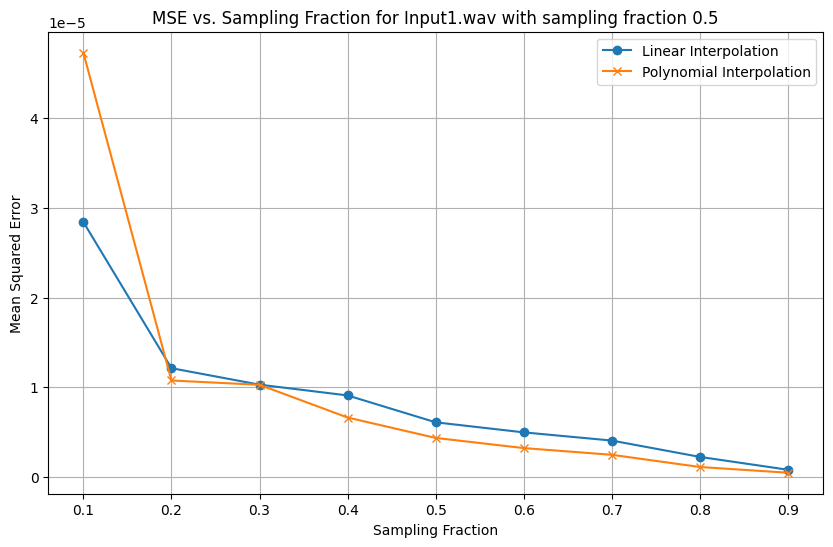

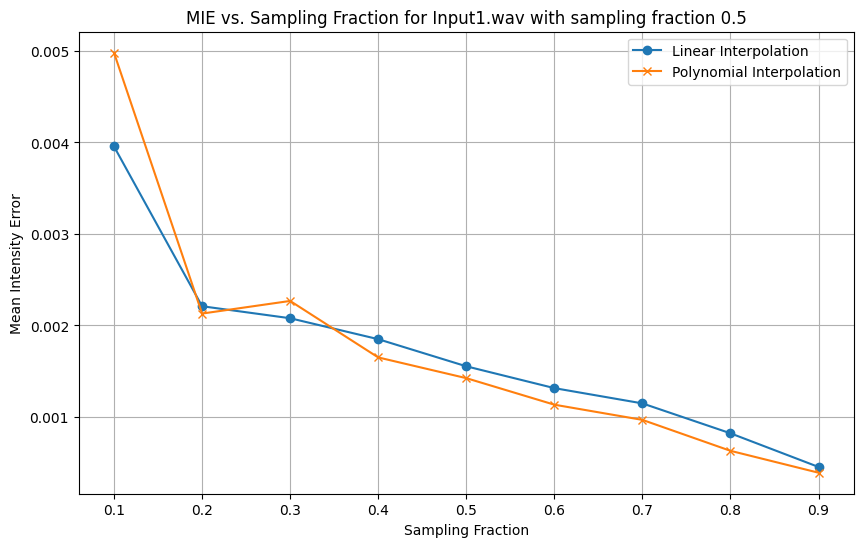

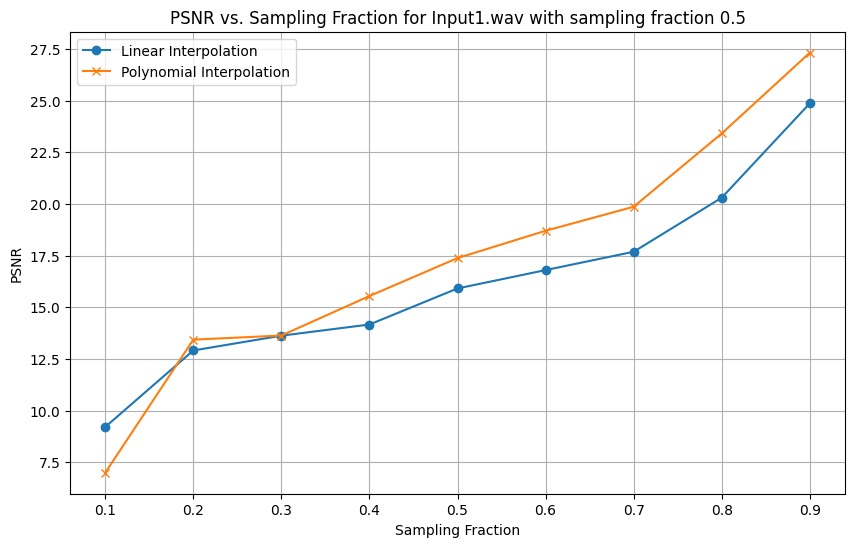

In [16]:
sampling_fractions = np.linspace(0.1, 0.9, 9)
linear_mse = []
polynomial_mse = []
linear_mie = []
polynomial_mie = []
linear_psnr = []
polynomial_psnr = []
np.random.seed(42)
# Iterate over sampling fractions
for fraction in sampling_fractions:
    # Simulate non-uniform sampling
    non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal, fraction)
    
    # Perform interpolations
    linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)
    polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask)
    
    # Reconstruct signals
    linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
    polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)
    
    # Calculate MSE
    mse_linear = evaluate_mse(signal, linear_reconstructed_signal)
    mse_polynomial = evaluate_mse(signal, polynomial_reconstructed_signal)

    # Calculate MIE
    mie_linear = MIE(signal, linear_reconstructed_signal)
    mie_polynomial = MIE(signal, polynomial_reconstructed_signal)

    # Calculate PSNR
    psnr_linear = PSNR(signal, linear_reconstructed_signal)
    psnr_polynomial = PSNR(signal, polynomial_reconstructed_signal)
    
    # Store MSE values
    linear_mse.append(mse_linear)
    polynomial_mse.append(mse_polynomial)

    # Store MIE values
    linear_mie.append(mie_linear)
    polynomial_mie.append(mie_polynomial)

    # Store PSNR values
    linear_psnr.append(psnr_linear)
    polynomial_psnr.append(psnr_polynomial)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_mse, label='Linear Interpolation', marker='o')
plt.plot(sampling_fractions, polynomial_mse, label='Polynomial Interpolation', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_mie, label='Linear Interpolation', marker='o')
plt.plot(sampling_fractions, polynomial_mie, label='Polynomial Interpolation', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('Mean Intensity Error')
plt.title('MIE vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_psnr, label='Linear Interpolation', marker='o')
plt.plot(sampling_fractions, polynomial_psnr, label='Polynomial Interpolation', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('PSNR')
plt.title('PSNR vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

## Frequency Domain Interpolation ( Linear and 3-degree polynomial interpolation ) - 2nd Input
### With sampling fraction 0.5

MSE between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: 5.8486579323792165e-06
MIE between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: 0.0014788383428044
PSNR between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: 16.554983263984223
MSE between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: 3.783392101431158e-06
MIE between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: 0.0012146602927138087
PSNR between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: 18.44673195298933


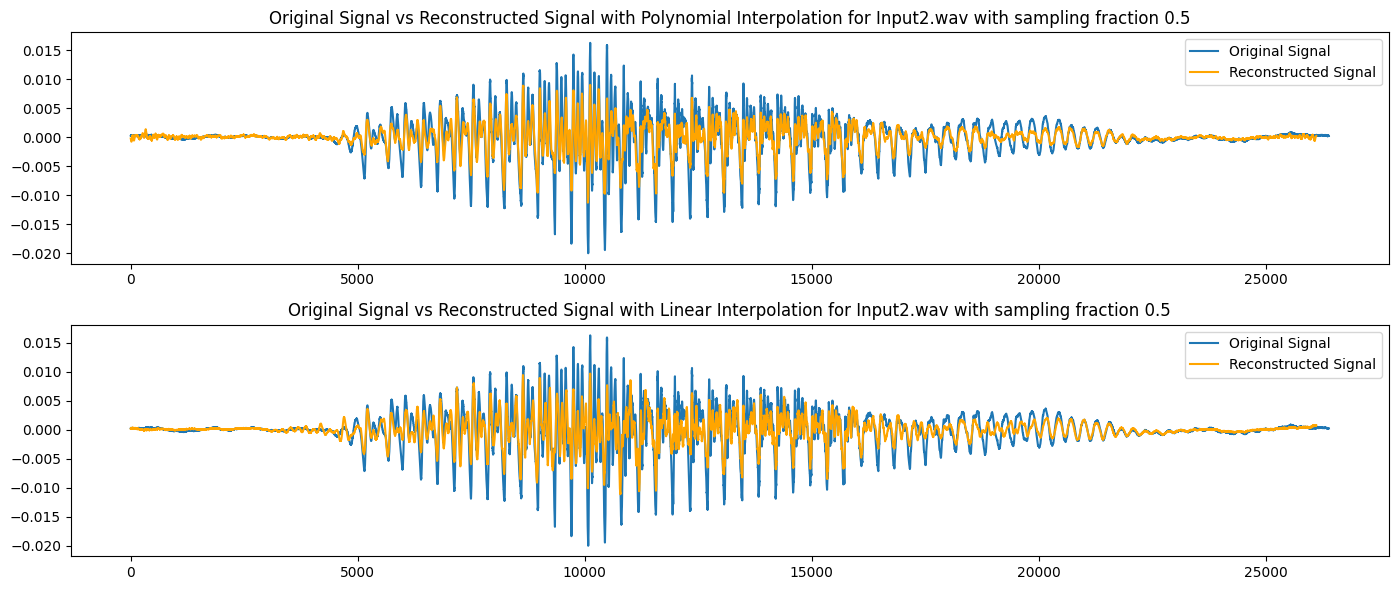

In [17]:
# Load the audio file
file_path = "./input/Input2.wav"
signal, sr = librosa.load(file_path, sr=None)
np.random.seed(42)

# Simulate non-uniform sampling
non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal)

# Perform frequency domain interpolation
linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)

degree = 3
polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree)

# Reconstruct signal from interpolated STFT
linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)

# Evaluate MSE
mse = evaluate_mse(signal, linear_reconstructed_signal)
mie = MIE(signal, linear_reconstructed_signal)
psnr = PSNR(signal, linear_reconstructed_signal)
print(f"MSE between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using linear interpolation for Input2.wav with sampling fraction 0.5: {psnr}")

mse = evaluate_mse(signal, polynomial_reconstructed_signal)
mie = MIE(signal, polynomial_reconstructed_signal)
psnr = PSNR(signal, polynomial_reconstructed_signal)
print(f"MSE between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using polynomial interpolation for Input2.wav with sampling fraction 0.5: {psnr}")

# Plotting setup for visualizing original and reconstructed signals
plt.figure(figsize=(14, 6))

# Subplot for polynomial interpolation results
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Polynomial Interpolation for Input2.wav with sampling fraction 0.5")
plt.legend()
plt.plot(polynomial_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

# Subplot for linear interpolation results
plt.subplot(2, 1, 2)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Linear Interpolation for Input2.wav with sampling fraction 0.5")
plt.legend()
plt.plot(linear_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

## Frequency Domain Interpolation ( Linear and 3-degree polynomial interpolation ) - 3rd Input
### With sampling fraction 0.5

MSE between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: 5.311278514050624e-06
MIE between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: 0.0013756086856304384
PSNR between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: 15.599238477440807
MSE between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: 4.959389272419649e-06
MIE between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: 0.0013924383086403754
PSNR between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: 15.89694725120063


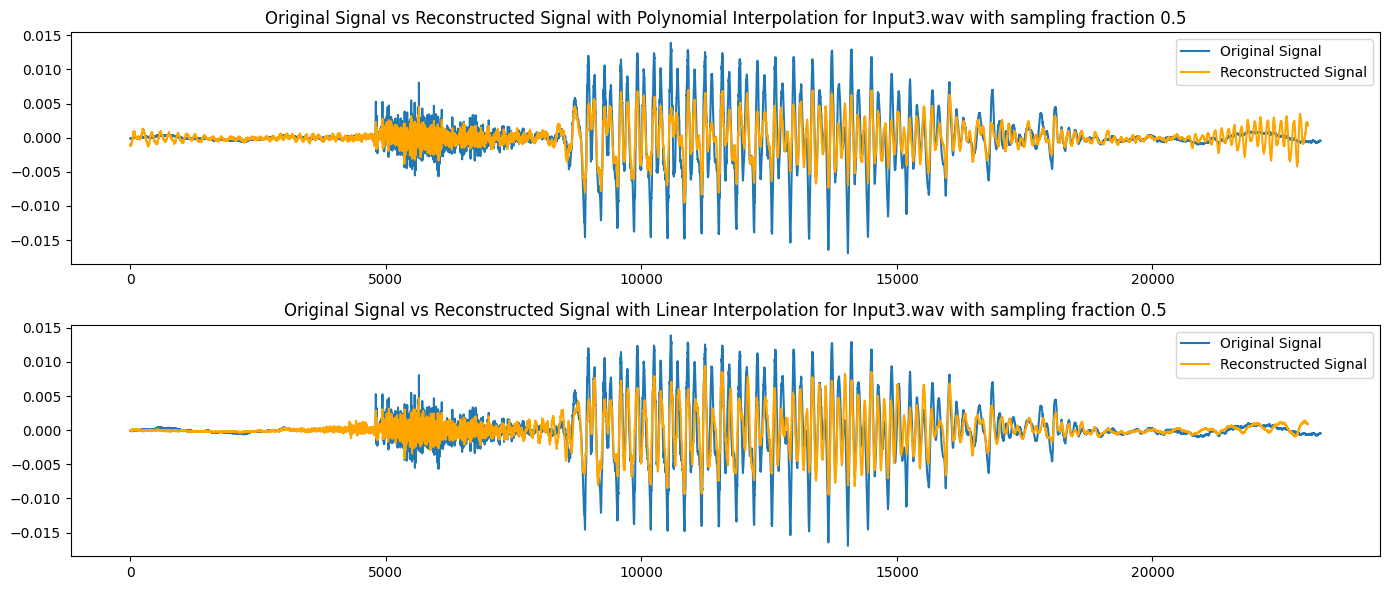

In [18]:
# Load the audio file
file_path = "./input/Input3.wav"
signal, sr = librosa.load(file_path, sr=None)
np.random.seed(42)

# Simulate non-uniform sampling
non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal)

# Perform frequency domain interpolation
linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)

degree = 3
polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask, degree)

# Reconstruct signal from interpolated STFT
linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)

# Evaluate MSE
mse = evaluate_mse(signal, linear_reconstructed_signal)
mie = MIE(signal, linear_reconstructed_signal)
psnr = PSNR(signal, linear_reconstructed_signal)
print(f"MSE between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using linear interpolation for Input3.wav with sampling fraction 0.5: {psnr}")

mse = evaluate_mse(signal, polynomial_reconstructed_signal)
mie = MIE(signal, polynomial_reconstructed_signal)
psnr = PSNR(signal, polynomial_reconstructed_signal)
print(f"MSE between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using polynomial interpolation for Input3.wav with sampling fraction 0.5: {psnr}")

# Plot original and reconstructed signal
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Polynomial Interpolation for Input3.wav with sampling fraction 0.5")
plt.legend()
plt.plot(polynomial_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(signal, label="Original Signal")
plt.title("Original Signal vs Reconstructed Signal with Linear Interpolation for Input3.wav with sampling fraction 0.5")
plt.legend()
plt.plot(linear_reconstructed_signal, label="Reconstructed Signal", color='orange')
plt.legend()

plt.tight_layout()
plt.show()

## Inverse Non Uniform Fourier Transform ( INUFT )

### With sampling fraction of 0.5

MSE between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: 8.308897122333292e-06
MIE between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: 0.0019443848868831992
PSNR between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: 14.544178247451782


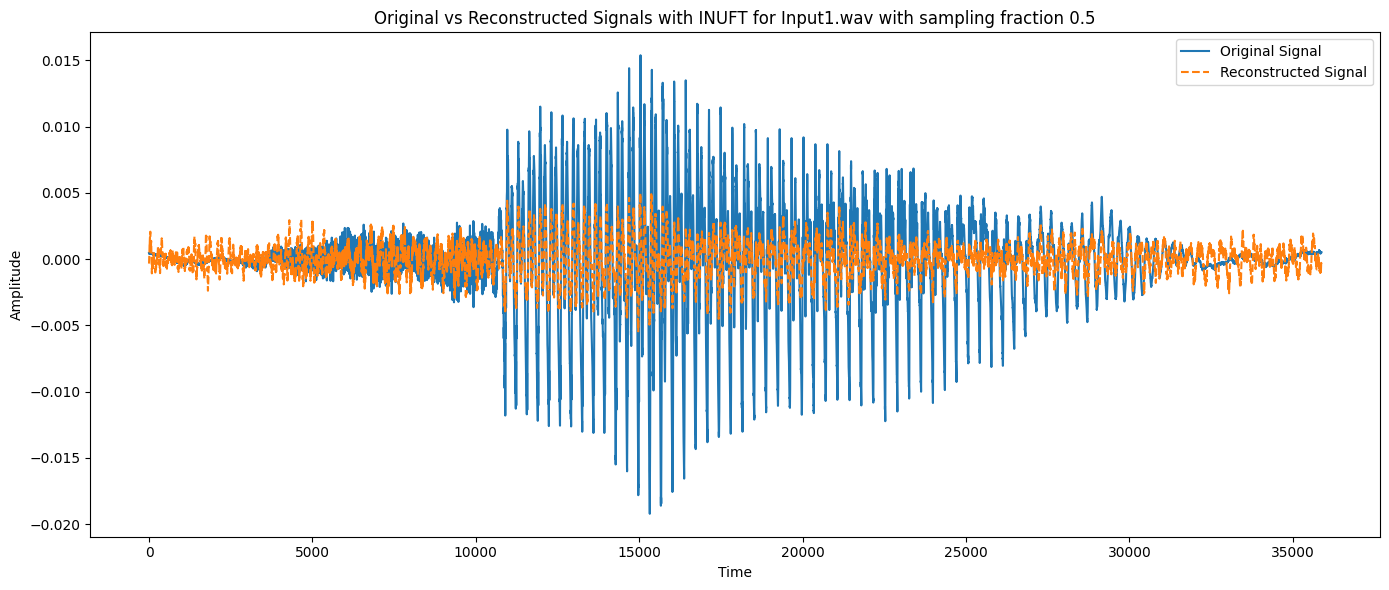

In [19]:
from pynufft import NUFFT

np.random.seed(42)

# Load an audio signal
file_path = "./input/Input1.wav"  # Update this to the path of your .wav file
signal, sr = librosa.load(file_path, sr=None)

# Assuming `signal` is your time-domain signal
n = len(signal)
Nd = (n,)  # Size of the signal
Kd = (2*n,)  # Size of frequency domain, oversampling for better accuracy
Jd = (6,)  # Size of interpolator
def INUFT(sampling_rate=0.5):
    k = int(n * sampling_rate)  # Number of non-uniform points, 50% of the total number of samples
    non_uniform_points = np.sort(np.random.uniform(-np.pi, np.pi, k))

    # Initialize NUFFT object
    nufft_obj = NUFFT()
    nufft_obj.plan(om=non_uniform_points[:, np.newaxis], Nd=Nd, Kd=Kd, Jd=Jd)

    # Forward NUFFT to simulate non-uniformly sampled frequency components
    non_uniform_freq_components = nufft_obj.forward(signal)
    reconstructed_signal = nufft_obj.adjoint(non_uniform_freq_components)
    return reconstructed_signal

reconstructed_signal = INUFT() 
mse = evaluate_mse(signal, reconstructed_signal.real)
mie = MIE(signal, reconstructed_signal.real)
psnr = PSNR(signal, reconstructed_signal.real)
print(f"MSE between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using INUFT for Input1.wav with sampling fraction 0.5: {psnr}")

# Assuming the original signal and reconstructed signal are of the same length
plt.figure(figsize=(14, 6))
plt.plot(signal, label='Original Signal')
plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signals with INUFT for Input1.wav with sampling fraction 0.5')
plt.tight_layout()
plt.show()

## MSE comparison between Linear Interpolation ( FDI ) and INUFT with various sampling rates 

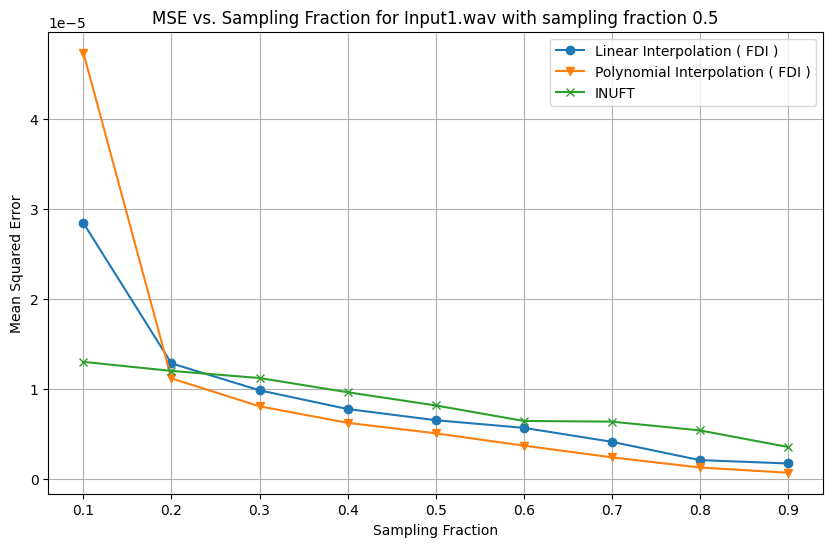

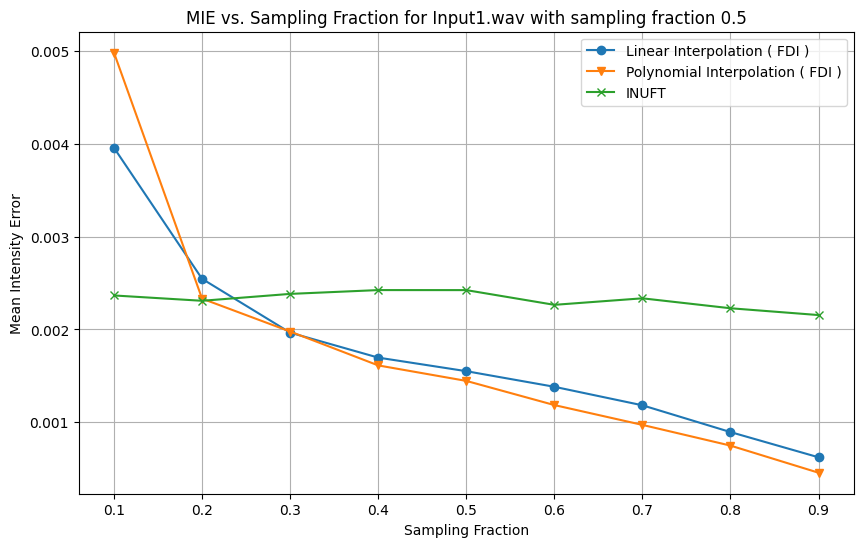

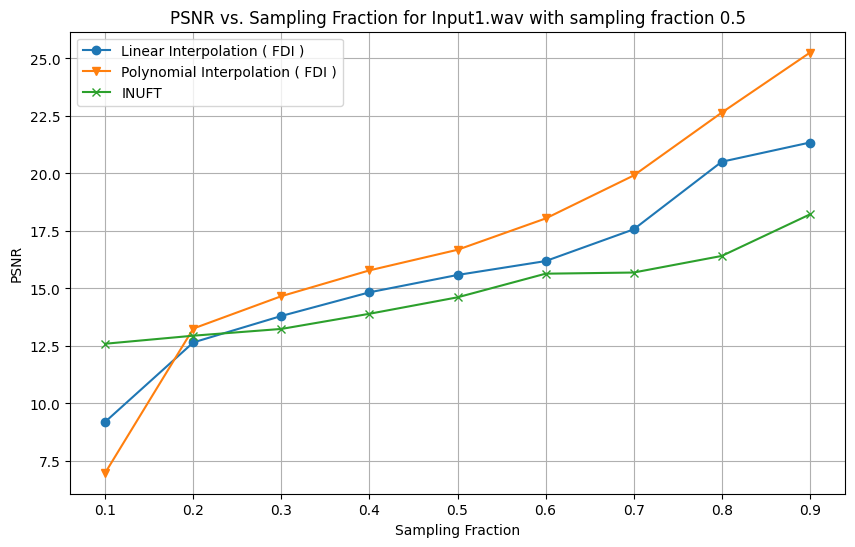

In [20]:
sampling_fractions = np.linspace(0.1, 0.9, 9)
linear_mse = []
polynomial_mse = []
INUFT_mse = []
linear_mie = []
polynomial_mie = []
INUFT_mie = []
linear_psnr = []
polynomial_psnr = []
INUFT_psnr = []
np.random.seed(42)

# Iterate over sampling fractions
for fraction in sampling_fractions:
    # Simulate non-uniform sampling
    non_uniform_stft, mask, original_stft = simulate_non_uniform_sampling(signal, fraction)
    
    # Perform interpolations
    linear_interpolated_stft = frequency_domain_interpolation(non_uniform_stft)
    polynomial_interpolated_stft = polynomial_frequency_domain_interpolation(non_uniform_stft, mask)
    
    # Reconstruct signals
    linear_reconstructed_signal = reconstruct_signal(linear_interpolated_stft)
    polynomial_reconstructed_signal = reconstruct_signal(polynomial_interpolated_stft)
    INUFT_reconstructed_signal = INUFT(fraction)
    
    # Calculate MSE
    mse_linear = evaluate_mse(signal, linear_reconstructed_signal)
    mse_polynomial = evaluate_mse(signal, polynomial_reconstructed_signal)
    mse_INUFT = evaluate_mse(signal, INUFT_reconstructed_signal)

    # Calculate MIE
    mie_linear = MIE(signal, linear_reconstructed_signal)
    mie_polynomial = MIE(signal, polynomial_reconstructed_signal)
    mie_INUFT = MIE(signal, INUFT_reconstructed_signal)

    # Calculate PSNR
    psnr_linear = PSNR(signal, linear_reconstructed_signal)
    psnr_polynomial = PSNR(signal, polynomial_reconstructed_signal)
    psnr_INUFT = PSNR(signal, INUFT_reconstructed_signal)
    
    # Store MSE values
    linear_mse.append(mse_linear)
    polynomial_mse.append(mse_polynomial)
    INUFT_mse.append(mse_INUFT)

    # Store MIE values
    linear_mie.append(mie_linear)
    polynomial_mie.append(mie_polynomial)
    INUFT_mie.append(mie_INUFT)

    # Store PSNR values
    linear_psnr.append(psnr_linear)
    polynomial_psnr.append(psnr_polynomial)
    INUFT_psnr.append(psnr_INUFT)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_mse, label='Linear Interpolation ( FDI )', marker='o')
plt.plot(sampling_fractions, polynomial_mse, label='Polynomial Interpolation ( FDI )', marker='v')
plt.plot(sampling_fractions, INUFT_mse, label='INUFT', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_mie, label='Linear Interpolation ( FDI )', marker='o')
plt.plot(sampling_fractions, polynomial_mie, label='Polynomial Interpolation ( FDI )', marker='v')
plt.plot(sampling_fractions, INUFT_mie, label='INUFT', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('Mean Intensity Error')
plt.title('MIE vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(sampling_fractions, linear_psnr, label='Linear Interpolation ( FDI )', marker='o')
plt.plot(sampling_fractions, polynomial_psnr, label='Polynomial Interpolation ( FDI )', marker='v')
plt.plot(sampling_fractions, INUFT_psnr, label='INUFT', marker='x')
plt.xlabel('Sampling Fraction')
plt.ylabel('PSNR')
plt.title('PSNR vs. Sampling Fraction for Input1.wav with sampling fraction 0.5')
plt.legend()
plt.grid(True)
plt.show()

## Inverse Non Uniform Fourier Transform ( INUFT ) - 2nd input
### With sampling fraction 0.5

MSE between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: 8.042242370720487e-06
MIE between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: 0.0018753529293462634
PSNR between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: 15.171774625778198


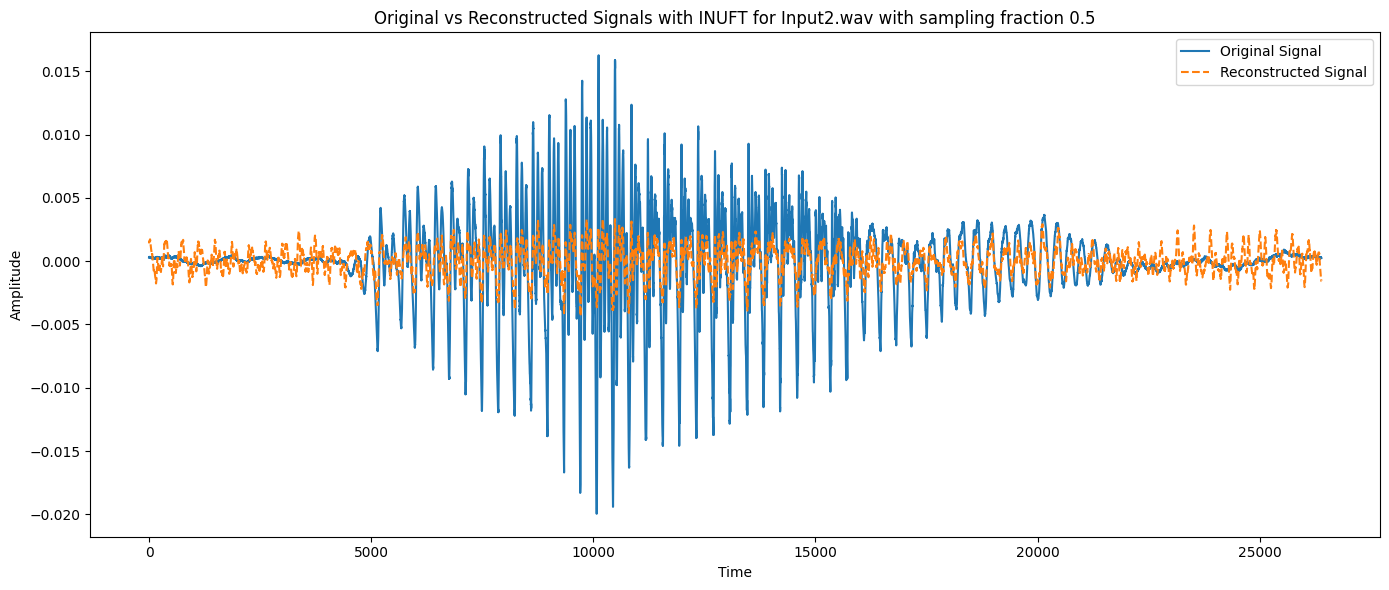

In [21]:
np.random.seed(42)

# Load an audio signal
file_path = "./input/Input2.wav"  # Update this to the path of your .wav file
signal, sr = librosa.load(file_path, sr=None)

# Assuming `signal` is your time-domain signal
n = len(signal)
Nd = (n,)  # Size of the signal
Kd = (2*n,)  # Size of frequency domain, oversampling for better accuracy
Jd = (6,)  # Size of interpolator
def INUFT(sampling_rate=0.5):
    k = int(n * sampling_rate)  # Number of non-uniform points, 50% of the total number of samples
    non_uniform_points = np.sort(np.random.uniform(-np.pi, np.pi, k))

    # Initialize NUFFT object
    nufft_obj = NUFFT()
    nufft_obj.plan(om=non_uniform_points[:, np.newaxis], Nd=Nd, Kd=Kd, Jd=Jd)

    # Forward NUFFT to simulate non-uniformly sampled frequency components
    non_uniform_freq_components = nufft_obj.forward(signal)
    reconstructed_signal = nufft_obj.adjoint(non_uniform_freq_components)
    return reconstructed_signal

reconstructed_signal = INUFT()
mse = evaluate_mse(signal, reconstructed_signal.real)
mie = MIE(signal, reconstructed_signal.real)
psnr = PSNR(signal, reconstructed_signal.real)
print(f"MSE between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using INUFT for Input2.wav with sampling fraction 0.5: {psnr}")

# Assuming the original signal and reconstructed signal are of the same length
plt.figure(figsize=(14, 6))
plt.plot(signal, label='Original Signal')
plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signals with INUFT for Input2.wav with sampling fraction 0.5')
plt.tight_layout()
plt.show()

## Inverse Non Uniform Fourier Transform ( INUFT ) - 3rd input
### With sampling fraction 0.5

MSE between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: 7.379819180641789e-06
MIE between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: 0.001791803166270256
PSNR between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: 14.170771837234497


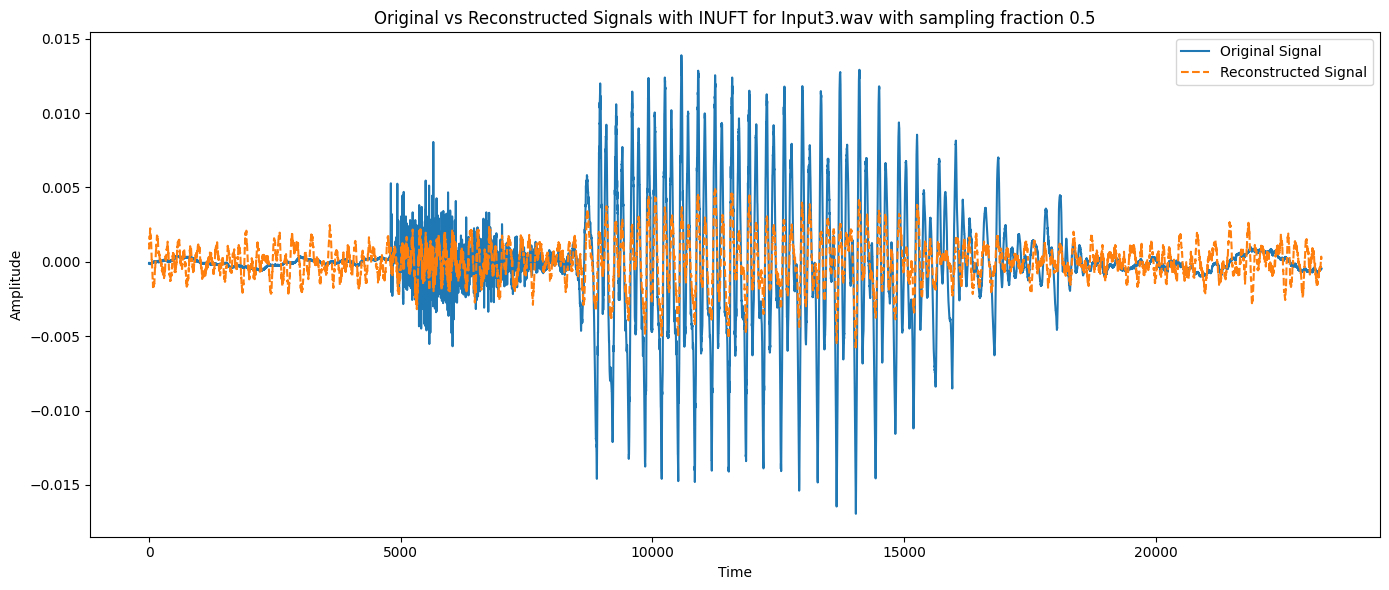

In [22]:
np.random.seed(42)

# Load an audio signal
file_path = "./input/Input3.wav"  # Update this to the path of your .wav file
signal, sr = librosa.load(file_path, sr=None)

# Assuming `signal` is your time-domain signal
n = len(signal)
Nd = (n,)  # Size of the signal
Kd = (2*n,)  # Size of frequency domain, oversampling for better accuracy
Jd = (6,)  # Size of interpolator
def INUFT(sampling_rate=0.5):
    k = int(n * sampling_rate)  # Number of non-uniform points, 50% of the total number of samples
    non_uniform_points = np.sort(np.random.uniform(-np.pi, np.pi, k))

    # Initialize NUFFT object
    nufft_obj = NUFFT()
    nufft_obj.plan(om=non_uniform_points[:, np.newaxis], Nd=Nd, Kd=Kd, Jd=Jd)

    # Forward NUFFT to simulate non-uniformly sampled frequency components
    non_uniform_freq_components = nufft_obj.forward(signal)
    reconstructed_signal = nufft_obj.adjoint(non_uniform_freq_components)
    return reconstructed_signal

reconstructed_signal = INUFT()
mse = evaluate_mse(signal, reconstructed_signal.real)
mie = MIE(signal, reconstructed_signal.real)
psnr = PSNR(signal, reconstructed_signal.real)
print(f"MSE between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: {mse}")
print(f"MIE between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: {mie}")
print(f"PSNR between original and reconstructed signal using INUFT for Input3.wav with sampling fraction 0.5: {psnr}")

# Assuming the original signal and reconstructed signal are of the same length
plt.figure(figsize=(14, 6))
plt.plot(signal, label='Original Signal')
plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signals with INUFT for Input3.wav with sampling fraction 0.5')
plt.tight_layout()
plt.show()